
1. Stationarität prüfen
2. Differenzierung
3. Bestimmen der Parameter p, d und q für das ARIMA-Modell.
4. ARIMA-Modell auswählen
5. Modell diagnostizieren
6. Prognosen erstellen

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats

In [165]:
df = pd.read_csv('monthly_csv.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df.set_index('Date', inplace=True)
df = df[df.index >= '1971-01-01']
df.head()

,Price
Date,
1971-01-01,37.868
1971-02-01,38.716
1971-03-01,38.873
1971-04-01,39.001
1971-05-01,40.493


Vor 1971 gab es keine signifikanten Preisveränderungen, deshalb wird Zeitreihe ab diesem Zeitpunkt betrachtet.

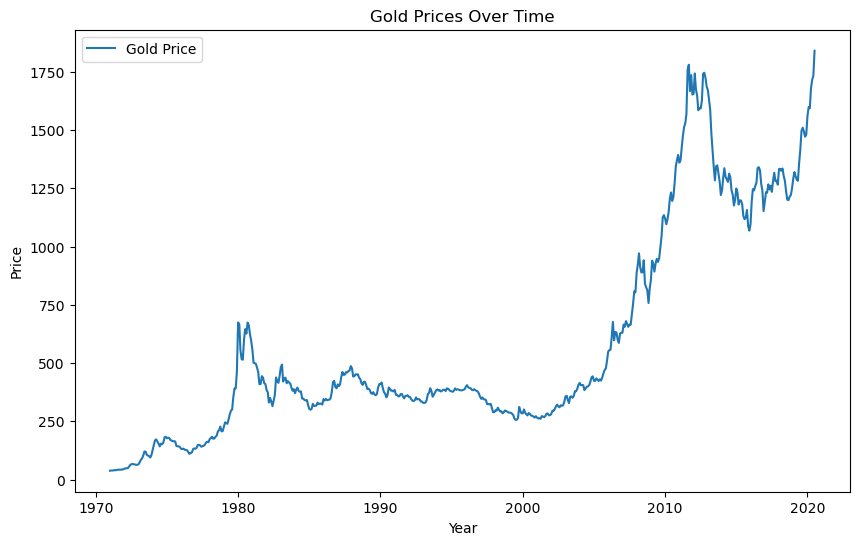

In [166]:
# Plot der ursprünglichen Zeitreihe
plt.figure(figsize=(10, 6))
plt.plot(df['Price'], label='Gold Price')
plt.title('Gold Prices Over Time')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

In [167]:
# Augmented Dickey-Fuller-Test zur Überprüfung der Stationarität
result = adfuller(df['Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values (1%):', result[4]["1%"])
print('Critical Values (5%):', result[4]["5%"])
print('Critical Values (10%):', result[4]["10%"])

ADF Statistic: 0.2368633123125436
p-value: 0.974254988465328
Critical Values (1%): -3.441616425652826
Critical Values (5%): -2.866510292004876
Critical Values (10%): -2.5694170294713863


**p-Value**, weit über 0,05, daher ist die Zeitreihe nicht-stationär und muss differenziert werden.

**ADF-Statistics:** kritische Werte sind kleiner als die ADF Statistic, daher kann die Nullhypothese abgelehnt werden.

In [168]:
df['lag1'] = df['Price'].diff()
df['lag1'] = df['lag1'].fillna(0)

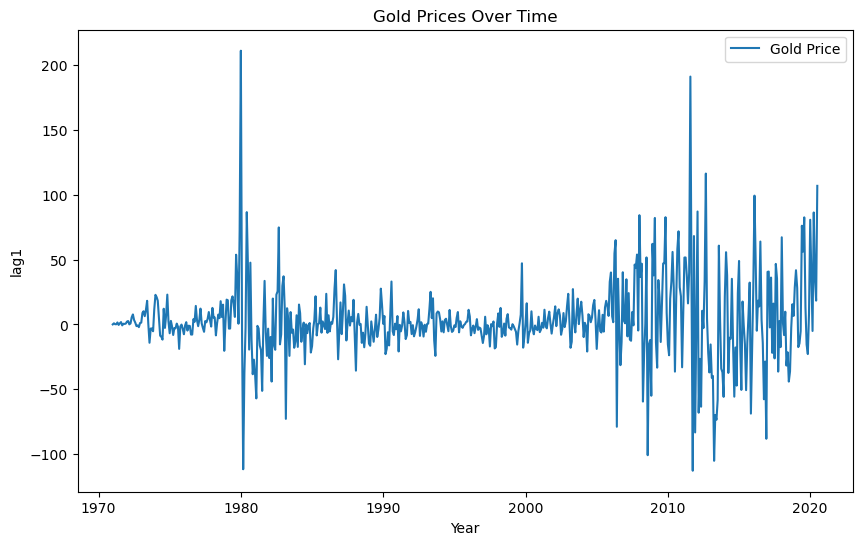

In [169]:
# Plot Lag 1
plt.figure(figsize=(10, 6))
plt.plot(df['lag1'], label='Gold Price')
plt.title('Gold Prices Over Time')
plt.xlabel('Year')
plt.ylabel('lag1')
plt.legend()
plt.show()

In [170]:
result = adfuller(df['lag1'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values (1%):', result[4]["1%"])
print('Critical Values (5%):', result[4]["5%"])
print('Critical Values (10%):', result[4]["10%"])

ADF Statistic: -5.256494053812523
p-value: 6.734029518540293e-06
Critical Values (1%): -3.4415970480373046
Critical Values (5%): -2.866501759246704
Critical Values (10%): -2.5694124827594296


Adf-Statistic unter ktitischen Werten -> Nullhypothese wird abgelehnt, weil p-Wert unter Signifikanzniveau -> Zeitreihe unterliegt Stationarität 

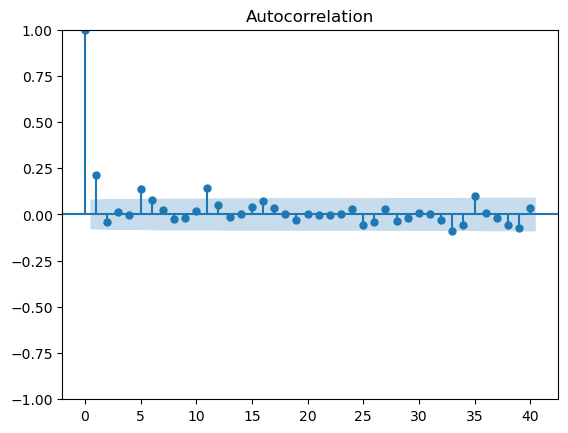

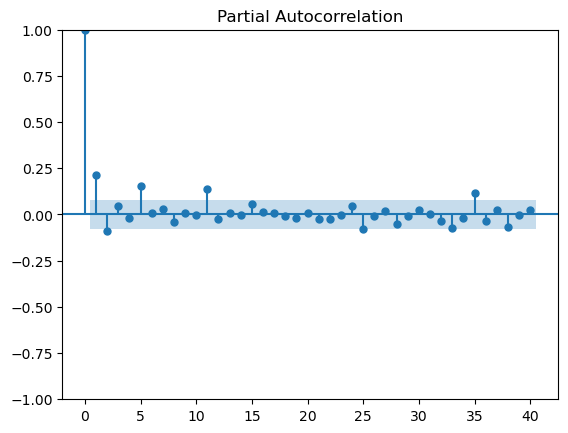

In [171]:
plot_acf(df['lag1'], lags=40)
plot_pacf(df['lag1'], lags=40)
plt.show()

4-5 Spikes über Signifikanzniveau von 0,1. Diese weisen nur auf eine leichte Autokorrelation hin.

-> PACF und ACF sind sich relativ ähnlich. Korrelation zwischen Werten und Lags bestimmt über direkte Beziehungen und nicht über die Zwischenwerte.

In [172]:
# Autmatisierte Festlegung der Werte für p d und q.
# Mittels einer verschachtelten Schleife werden alle Möglichkeiten durchgetestet.
# In der If-Bedingung wird über Vergleiche auf das beste Modell gesetzt.
best_aic = np.inf
best_order = None
best_mdl = None

pq_rng = range(5)  
d_rng = range(5)   

for p in pq_rng:
    for d in d_rng:
        for q in pq_rng:
            try:
                temp_model = ARIMA(df['Price'], order=(p, d, q)).fit()
                temp_aic = temp_model.aic
                if temp_aic < best_aic:
                    best_aic = temp_aic
                    best_order = (p, d, q)
                    best_mdl = temp_model
            except: continue

print('Best ARIMA model order:', best_order)
print(best_mdl.summary())

/Users/m.dederichs/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/m.dederichs/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/m.dederichs/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/m.dederichs/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/m.dederichs/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No fr

Best ARIMA model order: (4, 2, 4)
                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  595
Model:                 ARIMA(4, 2, 4)   Log Likelihood               -2827.353
Date:                Sat, 22 Jun 2024   AIC                           5672.706
Time:                        15:50:14   BIC                           5712.173
Sample:                    01-01-1971   HQIC                          5688.078
                         - 07-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3686      0.068      5.403      0.000       0.235       0.502
ar.L2         -0.2059      0.081     -2.558      0.011      -0.364      -0.048
ar.L3         -0.7

/Users/m.dederichs/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-> Werte für p d und q = (4, 2, 4)

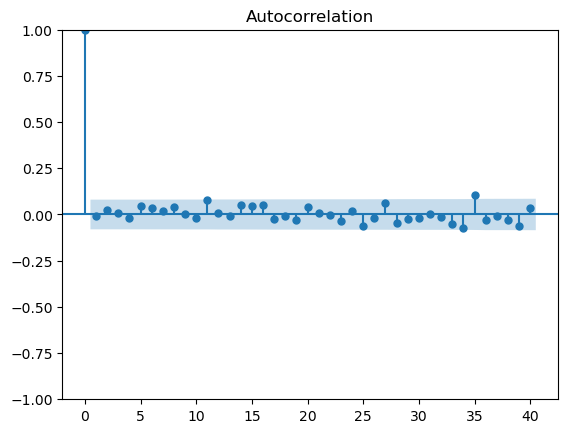

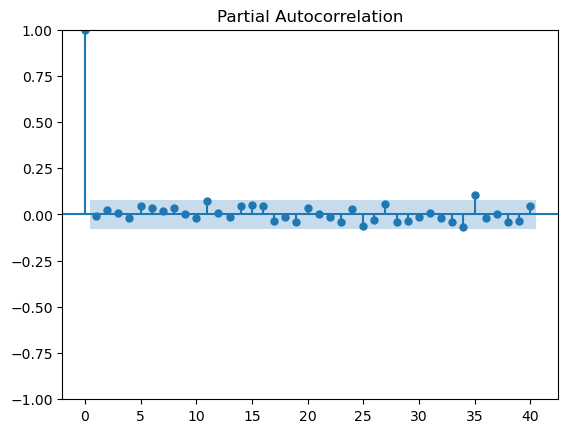

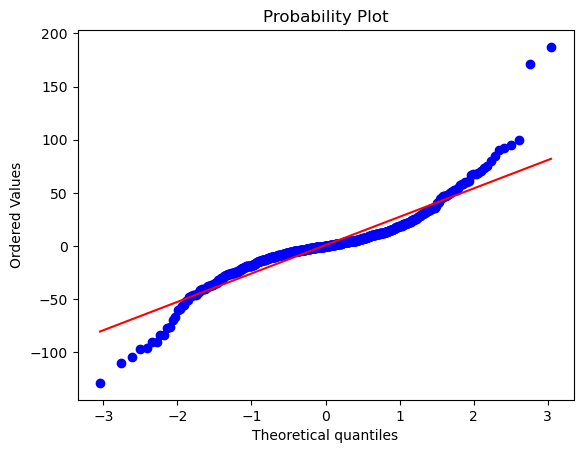

In [173]:
residuals = best_mdl.resid

# ACF und PACF der Residuals plotten
plot_acf(residuals, lags=40)
plot_pacf(residuals, lags=40)
plt.show()

# QQ-Plot der Residuals
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

Keine signifikanten Anzeichen von Autokorrelation in den Residuen.

Der Großteil der Zeitreihe wird durch unser Modell beschrieben. Es gibt nur Abweichungen in den Extrembereichen, am Anfang und Ende in der Zeitreihe  -> die Daten haben "schwere Tails".

2020-08-01    1866.471173
2020-09-01    1865.736752
2020-10-01    1865.410107
2020-11-01    1871.436057
2020-12-01    1887.310005
                 ...     
2028-03-01    2469.359917
2028-04-01    2475.301982
2028-05-01    2481.887861
2028-06-01    2489.184263
2028-07-01    2496.564875
Freq: MS, Name: predicted_mean, Length: 96, dtype: float64


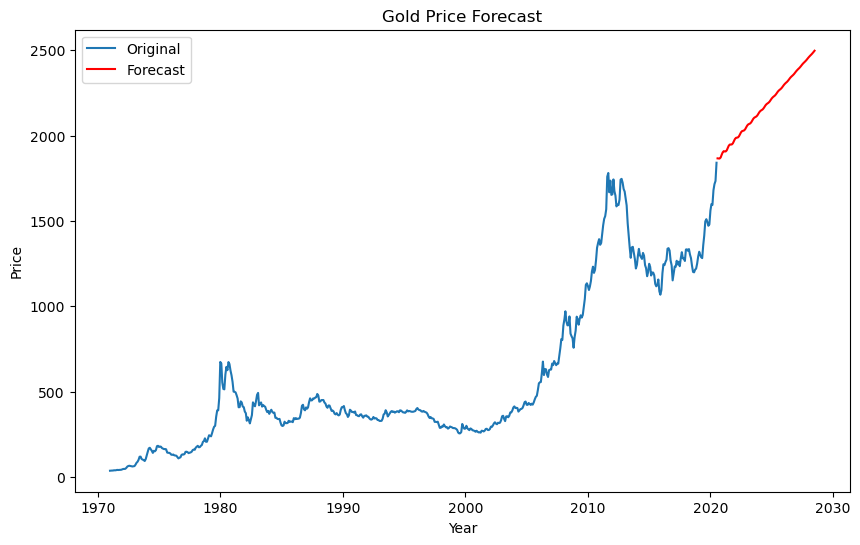

In [174]:
forecast = best_mdl.forecast(steps=96)  # Vorhersage für die nächsten 12 Monate
print(forecast)

# Plot der Vorhersagen
plt.figure(figsize=(10, 6))
plt.plot(df['Price'], label='Original')
plt.plot(forecast, label='Forecast', color='red')
plt.title('Gold Price Forecast')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

https://www.finanzen.net/rohstoffe/goldpreis/chart